In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd

In [3]:
import warnings
warnings.filterwarnings('ignore')

import os

import re 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import pyplot
import seaborn as sns

from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Bidirectional, Flatten
from keras.models import Model

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import tensorflow 
print(tensorflow.__version__)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2.6.0


In [4]:
# display all dataframe columns
pd.options.display.max_columns = None

# to set the limit to 3 decimals
pd.options.display.float_format = '{:.7f}'.format

# display all dataframe rows
pd.options.display.max_rows = None

In [5]:
df = pd.read_json("https://raw.githubusercontent.com/rishabhmisra/News-Headlines-Dataset-For-Sarcasm-Detection/master/Sarcasm_Headlines_Dataset.json", lines=True)
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


In [7]:
df.shape

(28619, 3)

In [8]:
df['is_sarcastic'].value_counts()

0    14985
1    13634
Name: is_sarcastic, dtype: int64

In [9]:
df['source_of_text'] = df['article_link'].apply(lambda x:re.findall(r'\w+', x)[2])
df.head()

,is_sarcastic,headline,article_link,source_of_text
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...,theonion
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...,huffingtonpost
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...,huffingtonpost
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...,theonion
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...,theonion


In [10]:
df = df.drop(['article_link'],axis = 1)

In [11]:
df.head(5)

,is_sarcastic,headline,source_of_text
0,1,thirtysomething scientists unveil doomsday clo...,theonion
1,0,dem rep. totally nails why congress is falling...,huffingtonpost
2,0,eat your veggies: 9 deliciously different recipes,huffingtonpost
3,1,inclement weather prevents liar from getting t...,theonion
4,1,mother comes pretty close to using word 'strea...,theonion


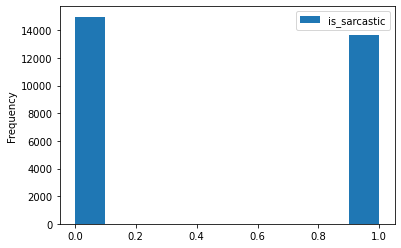

In [12]:
df.plot.hist(df['is_sarcastic'])

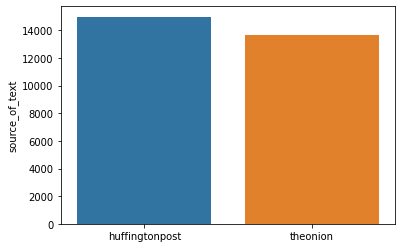

In [13]:
target_counts=df['source_of_text'].value_counts()
sns.barplot(y=target_counts,x=target_counts.index)

In [14]:
df['message_len'] = df['headline'].apply(lambda x: len(x.split(' ')))
df.head()

,is_sarcastic,headline,source_of_text,message_len
0,1,thirtysomething scientists unveil doomsday clo...,theonion,8
1,0,dem rep. totally nails why congress is falling...,huffingtonpost,13
2,0,eat your veggies: 9 deliciously different recipes,huffingtonpost,7
3,1,inclement weather prevents liar from getting t...,theonion,8
4,1,mother comes pretty close to using word 'strea...,theonion,9


In [15]:
df['headline']=df['headline'].str.lower()
# Code to remove the Hashtags from the text
df['headline']=df['headline'].apply(lambda x:re.sub(r'\B#\S+','',x))
# Code to remove the links from the text
df['headline']=df['headline'].apply(lambda x:re.sub(r"http\S+", "", x))
# Code to remove the Special characters from the text 
df['headline']=df['headline'].apply(lambda x:' '.join(re.findall(r'\w+', x)))
# Code to substitute the multiple spaces with single spaces
df['headline']=df['headline'].apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))
# Code to remove all the single characters in the text
df['headline']=df['headline'].apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))
# Remove the twitter handlers
df['headline']=df['headline'].apply(lambda x:re.sub('@[^\s]+','',x))

In [16]:
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text
    
df['headline_clean'] = df['headline'].apply(remove_stopwords)
df.head()

,is_sarcastic,headline,source_of_text,message_len,headline_clean
0,1,thirtysomething scientists unveil doomsday clo...,theonion,8,thirtysomething scientists unveil doomsday clo...
1,0,dem rep totally nails why congress is falling ...,huffingtonpost,13,dem rep totally nails congress falling short g...
2,0,eat your veggies 9 deliciously different recipes,huffingtonpost,7,eat veggies 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...,theonion,8,inclement weather prevents liar getting work
4,1,mother comes pretty close to using word stream...,theonion,9,mother comes pretty close using word streaming...


In [17]:
def tokenization(text):
    text = re.split('\W+', text)
    return text

df['tokenized'] = df['headline_clean'].apply(lambda x: tokenization(x.lower()))
df.head()

,is_sarcastic,headline,source_of_text,message_len,headline_clean,tokenized
0,1,thirtysomething scientists unveil doomsday clo...,theonion,8,thirtysomething scientists unveil doomsday clo...,"[thirtysomething, scientists, unveil, doomsday..."
1,0,dem rep totally nails why congress is falling ...,huffingtonpost,13,dem rep totally nails congress falling short g...,"[dem, rep, totally, nails, congress, falling, ..."
2,0,eat your veggies 9 deliciously different recipes,huffingtonpost,7,eat veggies 9 deliciously different recipes,"[eat, veggies, 9, deliciously, different, reci..."
3,1,inclement weather prevents liar from getting t...,theonion,8,inclement weather prevents liar getting work,"[inclement, weather, prevents, liar, getting, ..."
4,1,mother comes pretty close to using word stream...,theonion,9,mother comes pretty close using word streaming...,"[mother, comes, pretty, close, using, word, st..."


In [18]:
sarcastic = df[df['is_sarcastic']==0]['headline_clean']
sarcastic[:10]

1     dem rep totally nails congress falling short g...
2           eat veggies 9 deliciously different recipes
5                                     white inheritance
6                         5 ways file taxes less stress
9                            lots parents know scenario
10         lesbian consideredfather indiana amazing one
11          amanda peet told daughter sex isspecial hug
12              know regarding current treatments ebola
13    chris christie suggests hillary clinton blame ...
15    uber ceo travis kalanick stepping trump econom...
Name: headline_clean, dtype: object

In [19]:
not_sarcastic = df[df['is_sarcastic']==1]['headline_clean']
not_sarcastic[:10]

0     thirtysomething scientists unveil doomsday clo...
3          inclement weather prevents liar getting work
4     mother comes pretty close using word streaming...
7     richard bransonglobal warming donation nearly ...
8     shadow government getting large meet marriott ...
14           ford develops new suv runs purely gasoline
16    area boy enters jumping touching tops doorways...
17                            area man traveling gurney
21    guard video game strict orders repeatedly pace...
25     secret service agent secret david alan grier fan
Name: headline_clean, dtype: object

In [20]:
stemmer = nltk.SnowballStemmer("english")

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

df['headline_clean'] = df['headline_clean'].apply(stemm_text)
df.head()

,is_sarcastic,headline,source_of_text,message_len,headline_clean,tokenized
0,1,thirtysomething scientists unveil doomsday clo...,theonion,8,thirtysometh scientist unveil doomsday clock h...,"[thirtysomething, scientists, unveil, doomsday..."
1,0,dem rep totally nails why congress is falling ...,huffingtonpost,13,dem rep total nail congress fall short gender ...,"[dem, rep, totally, nails, congress, falling, ..."
2,0,eat your veggies 9 deliciously different recipes,huffingtonpost,7,eat veggi 9 delici differ recip,"[eat, veggies, 9, deliciously, different, reci..."
3,1,inclement weather prevents liar from getting t...,theonion,8,inclement weather prevent liar get work,"[inclement, weather, prevents, liar, getting, ..."
4,1,mother comes pretty close to using word stream...,theonion,9,mother come pretti close use word stream correct,"[mother, comes, pretty, close, using, word, st..."


In [21]:
all_words=[]
for i in range(len(df['tokenized'])):
    a=df['tokenized'][i]
    for i in a:
        all_words.append(i)
all_words=pd.Series(np.array(all_words))

common_words=all_words.value_counts()[:100].rename_axis('Common Words').reset_index(name='count')


In [22]:
common_words

,Common Words,count
0,new,1526
1,trump,1396
2,man,1367
3,report,592
4,one,576
5,year,525
6,area,498
7,woman,481
8,says,478
9,donald,470


In [23]:
#Spliting it into training and testing 
X = df['headline_clean']
y = df['is_sarcastic']

# Split into train and test sets
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y,test_size = 0.25,random_state=42)
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

21464 21464
7155 7155


In [24]:
vocab_size = 8000
max_len = 128
embedding_dim = 50

In [25]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
tok = Tokenizer(num_words=vocab_size)
tok.fit_on_texts(x_train)
sequences = tok.texts_to_sequences(x_train)
sequences_matrix = sequence.pad_sequences(sequences, padding="post", truncating="post", maxlen=max_len)

In [26]:
print("\nTraining sequences:\n", sequences)


Training sequences:
 [[3359, 3087, 1963, 1626, 587], [1, 1159, 109, 966, 1862], [764, 1277, 32, 310, 470, 6951, 147, 160], [550, 1001, 4749, 1217, 4125, 424, 1278], [1627, 550, 44, 212, 831], [537, 225, 2852, 249, 561], [1033, 1160, 446, 765, 6952, 1077, 1218], [2486, 6953, 194, 116, 5574, 1382, 1078], [53, 3674, 538, 1383, 2074, 1219], [384, 2853, 238], [420, 702, 161, 562, 63, 2854], [9, 375, 62, 1693, 1161, 2652, 121], [355, 669, 170, 6954], [53, 24, 4750, 301, 433, 575, 480, 325, 326, 2487], [3675, 5575, 481, 3676, 49, 3360, 1279, 1445, 13, 148], [1034, 220, 596, 868, 71, 125], [2653, 233, 286, 1769, 8, 6955], [], [250, 868, 1217, 72, 3677, 831], [471, 1964, 385, 783, 356], [617, 2200, 832, 1504, 833, 116, 6956, 460, 766], [4126, 102, 9, 8, 130, 1339, 11], [1446, 2654, 596, 111, 13, 669, 869], [1162, 576, 294, 9, 13, 19, 4751, 1384, 1385, 6957], [4752, 634, 539, 280, 267, 385, 1447], [2855, 1628, 104, 225], [6958, 39, 803, 497, 184, 9, 1770, 32], [4, 1079, 123, 213, 2339, 2201, 18

In [27]:
print("\n Padded training sequences:\n", sequences_matrix)
print("\n Padded training shape:", sequences_matrix.shape)
print("Padded Training sequences data type:", type(sequences_matrix))


 Padded training sequences:
 [[3359 3087 1963 ...    0    0    0]
 [   1 1159  109 ...    0    0    0]
 [ 764 1277   32 ...    0    0    0]
 ...
 [  27 1404  444 ...    0    0    0]
 [1941  258   19 ...    0    0    0]
 [6726 2574  182 ...    0    0    0]]

 Padded training shape: (21464, 128)
Padded Training sequences data type: <class 'numpy.ndarray'>


In [28]:
num_words = len( tok.word_index)+ 1
print(num_words)

21427


In [29]:
def load_glove_model(File):
    print("Loading Glove Model")
    glove_model = {}
    with open(File,'r') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embedding = np.array(split_line[1:], dtype=np.float64)
            glove_model[word] = embedding
    print(f"{len(glove_model)} words loaded!")
    return glove_model

In [30]:
glove_model = load_glove_model('/content/drive/MyDrive/statistical NLP 2/glove.6B.50d.txt')

Loading Glove Model
400000 words loaded!


In [31]:
embedding_matrix = np.zeros((num_words, 50))

In [32]:
for word, i in tok.word_index.items():
  embedding_vector = glove_model.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [33]:
embedding_matrix.shape

(21427, 50)

In [46]:
# define a DNN model with an Embedding layer
from tensorflow import keras
from keras import layers
import tensorflow as tf
from keras.models import Sequential

model = Sequential()
model.add(Embedding(num_words, embedding_dim, weights=[embedding_matrix],input_length=max_len))
model.add(Bidirectional(LSTM(256,return_sequences=True)))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
                         
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
                         
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 128, 50)           1071350   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128, 512)          628736    
_________________________________________________________________
flatten_2 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               8388736   
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                

In [47]:
batch_size=512
epochs=10

In [48]:
history_model = model.fit(
    x=sequences_matrix,
    y=y_train,
    validation_data=(x_test, y_test),
    validation_split=0.1,
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,
    verbose=1,
)

Epoch 1/10
38/38 [==============================] - 16s 308ms/step - loss: 0.6095 - accuracy: 0.6627 - val_loss: 0.5582 - val_accuracy: 0.7126
Epoch 2/10
38/38 [==============================] - 11s 283ms/step - loss: 0.5280 - accuracy: 0.7391 - val_loss: 0.5133 - val_accuracy: 0.7517
Epoch 3/10
38/38 [==============================] - 11s 281ms/step - loss: 0.4444 - accuracy: 0.7922 - val_loss: 0.4818 - val_accuracy: 0.7746
Epoch 4/10
38/38 [==============================] - 11s 281ms/step - loss: 0.3449 - accuracy: 0.8478 - val_loss: 0.4636 - val_accuracy: 0.7941
Epoch 5/10
38/38 [==============================] - 11s 280ms/step - loss: 0.2689 - accuracy: 0.8868 - val_loss: 0.4838 - val_accuracy: 0.7904
Epoch 6/10
38/38 [==============================] - 11s 280ms/step - loss: 0.2269 - accuracy: 0.9075 - val_loss: 0.5642 - val_accuracy: 0.7923
Epoch 7/10
38/38 [==============================] - 11s 279ms/step - loss: 0.1945 - accuracy: 0.9210 - val_loss: 0.6622 - val_accuracy: 0.7811

In [49]:
def plot_loss_nd_accuracy(history):
    history_df=pd.DataFrame(history)
    history_df.loc[0:,['loss','val_loss']].plot()
    history_df.loc[0:,['accuracy','val_accuracy']].plot()

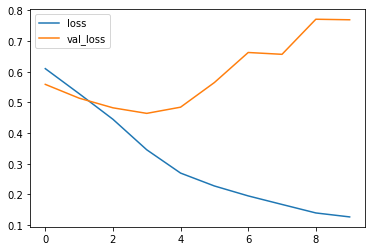

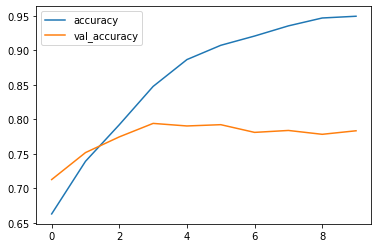

In [50]:
plot_loss_nd_accuracy(history_model.history)

-----------END-----------